# Investigate how network width and depths impact performance

## Main Questions

* Are two layers enough?
* Do we need wide networks?

In [12]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

run = 'rnn_frac'

folder = f'../../data/training/{run}/train'
merged_folder = f'../../data/training/{run}/merged'
bs_folder = f'../../data/training/baselines/train'
bs_merged_folder = f'../../data/training/baselines/merged'

plot_folder = f'plots/{run}'

make_dir(plot_folder)
make_dir(merged_folder)
make_dir(bs_merged_folder)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# file_names = ['metrics.parquet', 'confusion_matrix.parquet', 'synthetic_predicitions.parquet']
file_names = ['metrics.parquet']


def get_df(file_name, merged_folder, folder):
    m_file = os.path.join(merged_folder, file_name)
    if not os.path.isfile(m_file):
        df = merge_files_by_name(folder, file_name)
        df.to_parquet(m_file)
        return df
    else:
        return pd.read_parquet(m_file)

metrics_df, = (
    get_df(file_name, merged_folder, folder)
    for file_name in file_names
)

metrics_df = metrics_df.reset_index(drop=True)

baseline_df = get_df(file_names[0], bs_merged_folder, bs_folder)

In [14]:
baseline_df

,baseline,name,value,cv_split,epoch,set,strategy
0,onehot_mlp_graph_2,loss,3.050371,0,0,None,None
1,onehot_mlp_graph_2,mean_absolute_error,7.843695,0,0,train,greedy
2,onehot_mlp_graph_2,accuracy,0.024625,0,0,train,greedy
3,onehot_mlp_graph_2,mean_absolute_error,7.878100,0,0,train,sampling
4,onehot_mlp_graph_2,accuracy,0.048376,0,0,train,sampling
...,...,...,...,...,...,...,...
17995,onehot_mlp_graph,accuracy,0.346140,19,990,train,sampling
17996,onehot_mlp_graph,mean_absolute_error,2.747573,19,990,test,greedy
17997,onehot_mlp_graph,accuracy,0.538835,19,990,test,greedy
17998,onehot_mlp_graph,mean_absolute_error,3.834951,19,990,test,sampling


In [15]:
labels = list(set(metrics_df.columns) - set(['name', 'value', 'cv_split', 'epoch', 'set']))
print(labels)

metrics_df['label'] = ''
bw = ''
for l in labels:
    metrics_df['label'] += (bw + l + ':') + metrics_df[l].astype(str)
    bw = ' '

to_string = ['layers', 'hidden_size', 'batch_size']
to_string = list(set(to_string).intersection(set(metrics_df.columns)))
if len(to_string) > 0:
    metrics_df[to_string] = metrics_df[to_string].astype(str)
    # synthethetic_df[to_string] = synthethetic_df[to_string].astype(str)
    # confusion_matrix_df[to_string] = confusion_matrix_df[to_string].astype(str)

['strategy', 'fraction_training', 'lr', 'add_rnn']


In [16]:
w = (
    (baseline_df['set'] == 'test') & 
    (baseline_df['epoch'] == 990) & 
    (baseline_df['strategy'] == 'greedy') & 
    (baseline_df['baseline'] == 'onehot_mlp_graph_2') 
)

df = baseline_df[w]

baseline = df.groupby(['baseline', 'name'])['value'].median()
baseline

baseline            name               
onehot_mlp_graph_2  accuracy               0.489726
                    mean_absolute_error    2.867874
Name: value, dtype: float64

In [17]:
metrics_df.head()

,add_rnn,fraction_training,lr,name,value,cv_split,epoch,set,strategy,label
0,False,0.8,1.e-3,loss,2.986596,0,0,None,None,strategy:None fraction_training:0.8 lr:1.e-3 a...
1,False,0.8,1.e-3,mean_absolute_error,6.877104,0,0,train,greedy,strategy:greedy fraction_training:0.8 lr:1.e-3...
2,False,0.8,1.e-3,accuracy,0.113545,0,0,train,greedy,strategy:greedy fraction_training:0.8 lr:1.e-3...
3,False,0.8,1.e-3,mean_absolute_error,7.602191,0,0,train,sampling,strategy:sampling fraction_training:0.8 lr:1.e...
4,False,0.8,1.e-3,accuracy,0.055303,0,0,train,sampling,strategy:sampling fraction_training:0.8 lr:1.e...


In [24]:
metrics_df[metrics_df.add_rnn].fraction_training.max()

0.2

## Overview

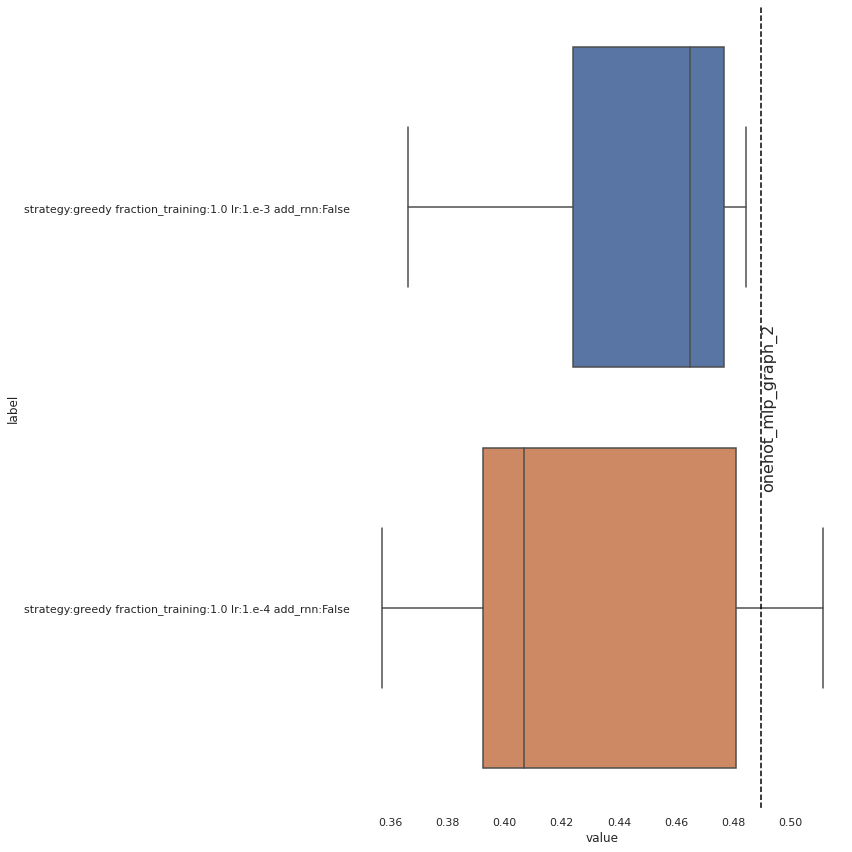

In [19]:
metric_name = 'accuracy'

w1 = (
    (metrics_df['set'] == 'test') & 
    (metrics_df['strategy'] == 'greedy') & 
    (metrics_df['fraction_training'] == 1) & 
    (metrics_df['epoch'] == metrics_df.epoch.max())
)

w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(labels)
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

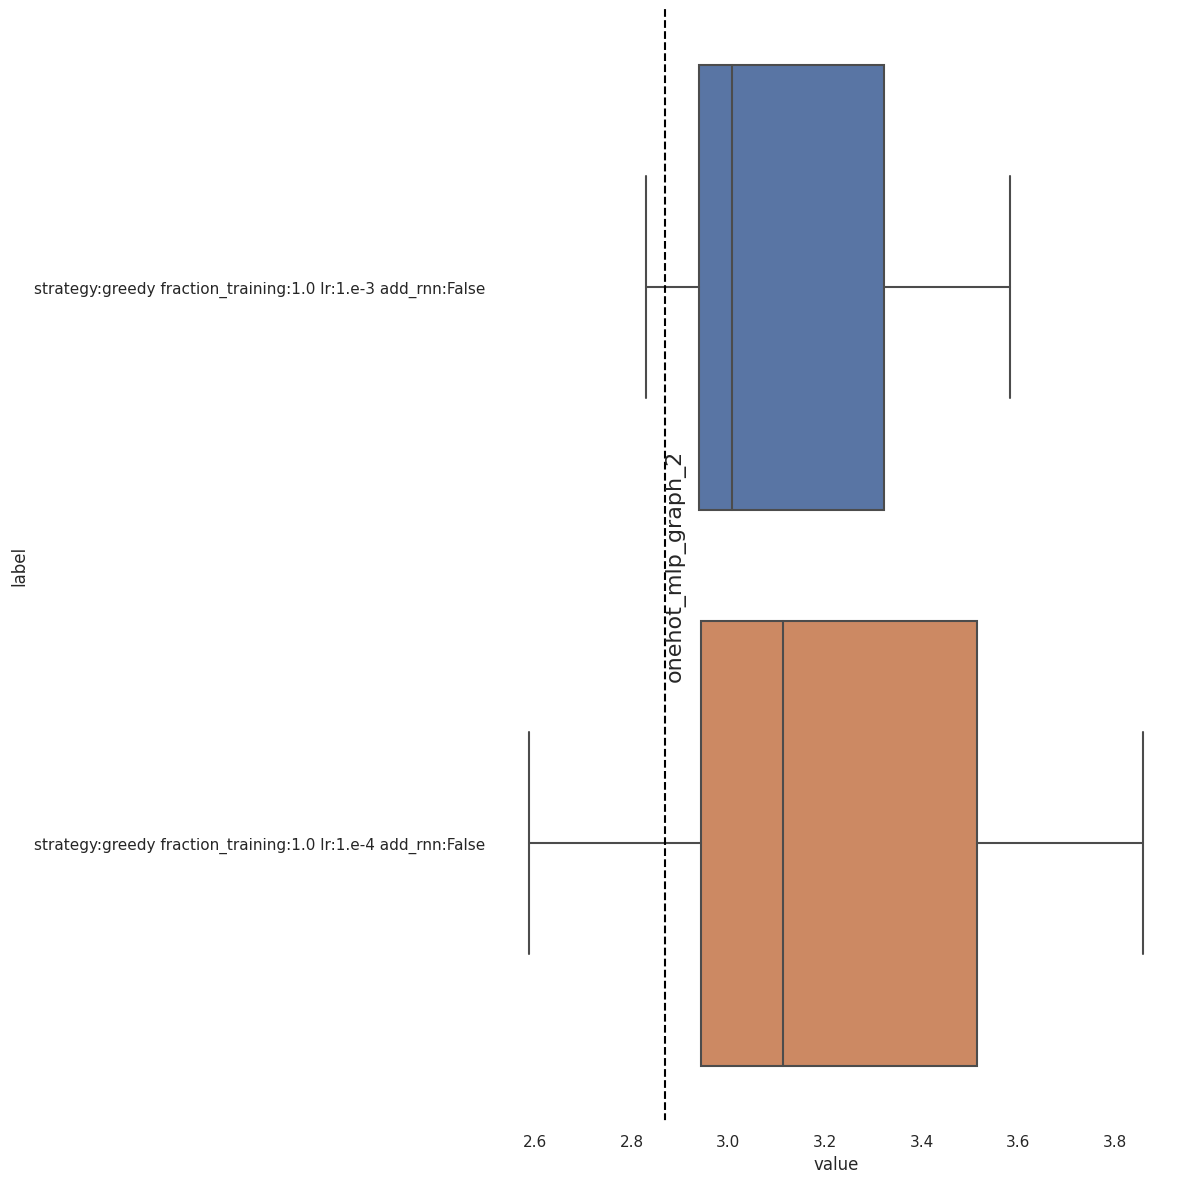

In [25]:
metric_name = 'mean_absolute_error'
w2 = (metrics_df['name'] == metric_name)
df = metrics_df[w1 & w2]

df = df.sort_values(labels)
sns.catplot(data=df, x='value', y='label', orient='h', kind='box', sharex=False, height=12)

for idx, dfg in baseline.groupby(level=0):
    plt.axvline(dfg[(idx, metric_name)], color='black', ls='--')
    plt.text(dfg[(idx, metric_name)], 0.5, idx, rotation=90, size=16, va='center')

In [26]:
df.head()

,add_rnn,fraction_training,lr,name,value,cv_split,epoch,set,strategy,label
85496,False,1.0,1.e-3,mean_absolute_error,2.829787,0,4990,test,greedy,strategy:greedy fraction_training:1.0 lr:1.e-3...
89996,False,1.0,1.e-3,mean_absolute_error,3.408506,1,4990,test,greedy,strategy:greedy fraction_training:1.0 lr:1.e-3...
94496,False,1.0,1.e-3,mean_absolute_error,2.950544,2,4990,test,greedy,strategy:greedy fraction_training:1.0 lr:1.e-3...
98996,False,1.0,1.e-3,mean_absolute_error,3.065844,3,4990,test,greedy,strategy:greedy fraction_training:1.0 lr:1.e-3...
103496,False,1.0,1.e-3,mean_absolute_error,3.581731,4,4990,test,greedy,strategy:greedy fraction_training:1.0 lr:1.e-3...


### First conclusion

* Hugh variance in the performance
* Numeric encoding has clearly lower performance

## Statistical analysis of grid

In [28]:
label_ref = {
    # 'fraction_training': 1,
    'batch_size': '5',
    'regularisation': 'none',
    'layers': 2,
    'hidden_size': 5,
    'lr': '1.e-4'
}

label_str = [f"C({l}, Treatment(reference='{label_ref[l]}'))" if l in label_ref else l for l in labels]

In [29]:
w = (
    (metrics_df['name'] == 'accuracy') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'greedy') & 
    # (metrics_df['layers'] == '2') & 
    (metrics_df['epoch'] == metrics_df.epoch.max())
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
# results = smf.glm(f"value ~ {'+'.join(label_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric accuracy - positive coef -> better')

results_df[results_df['P>|z|'] < 0.10].sort_values('Coef.')

metric accuracy - positive coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
add_rnn[T.True],-0.092418,0.038607,-2.393842,1.667293e-02,-0.168086,-0.016751
fraction_training,0.071238,0.027419,2.598103,9.374038e-03,0.017497,0.124978
Intercept,0.364556,0.016650,21.895094,2.893072e-106,0.331923,0.397190


### Accuracy

#### Strong evidence
* larger learning rate (1.e-3) is better
* ordinal x encoding (and to a lesser extend onehot) is better then numeric encoding
* higher number of neurons is better for onehot encodingß

In [30]:
w = (
    (metrics_df['name'] == 'mean_absolute_error') &
    (metrics_df['set'] == 'test') &
    (metrics_df['strategy'] == 'sampling') &
    (metrics_df['epoch'] == 990)
)
df = metrics_df[w]

m_str = [f'{a}*{b}' for a in label_str for b in label_str]

results = smf.glm(f"value ~ {'+'.join(m_str)}", data=df).fit()
results_df = results.summary2().tables[1]

print('metric mean_absolute_error - negative coef -> better')
results_df[results_df['P>|z|'] < 0.10].sort_values('Coef.')

metric mean_absolute_error - negative coef -> better


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
fraction_training,-1.215748,0.167883,-7.241649,4.432625e-13,-1.544792,-0.886704
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",-1.006844,0.143960,-6.993916,2.673184e-12,-1.289000,-0.724687
add_rnn[T.True],-0.567869,0.236383,-2.402325,1.629125e-02,-1.031171,-0.104567
"C(lr, Treatment(reference='1.e-4'))[T.1.e-3]:add_rnn[T.True]",0.721386,0.174648,4.130516,3.619505e-05,0.379083,1.063690
"fraction_training:C(lr, Treatment(reference='1.e-4'))[T.1.e-3]",0.813253,0.236936,3.432379,5.983112e-04,0.348868,1.277638
Intercept,5.248037,0.101946,51.478493,0.000000e+00,5.048226,5.447847


### mean absolute error

#### Strong evidence
* ordinal > numeric
* hidden 20 > hidden 5

## Best parameters

In [31]:
# w = (
#     (metrics_df['x_encoding'] == 'numeric')
# )
# df = metrics_df[w]
df = metrics_df

best_labels = {}
for m in ['mean_absolute_error', 'accuracy']:
    df = df.reset_index(drop=True)
    gb_col = list(set(df.columns) - set(['cv_split', 'value']))
    df_g = df.groupby(gb_col)['value'].median().reset_index()
    df_g = df_g.dropna(subset='value')
    w = (
        (df_g['name'] == m) &
        (df_g['set'] == 'test')
    )
    if m == 'mean_absolute_error':
        best = df_g.loc[df_g[w]['value'].idxmin()]
    else:
        best = df_g.loc[df_g[w]['value'].idxmax()]
    best_labels[m] = {l: best[l] for l in labels}

    print(f'Best performance for metric {m} is {best.label}.')
    w = (
        (df_g['label'] == best.label) &
        (df_g['epoch'] == 990)
    )

    print(df_g.loc[w, ['name', 'set', 'value']])
    print('================')
    # print(f'Best performance for metric {m} with a value of {best.value} is {best.label} in epoch {best.epoch}')



Best performance for metric mean_absolute_error is strategy:greedy fraction_training:1.0 lr:1.e-3 add_rnn:False.
                      name    set     value
12784             accuracy   test  0.452028
12786  mean_absolute_error   test  3.047543
12788             accuracy  train  0.456858
12790  mean_absolute_error  train  3.066609
Best performance for metric accuracy is strategy:greedy fraction_training:1.0 lr:1.e-3 add_rnn:False.
                      name    set     value
12784             accuracy   test  0.452028
12786  mean_absolute_error   test  3.047543
12788             accuracy  train  0.456858
12790  mean_absolute_error  train  3.066609


### Summary

* We have the highest accuracy and mae for
    * low regularisation 
    * hidden_size of 20
    * learning rate of 1.e-3
    * x-encoding onehot
* 3 layer is leading to a better mae, 2 layer to a higher accuracy

## Investigation of particular parameter

### Hidden Size and number of layer

strategy=greedy|add_rnn=False|epoch=990


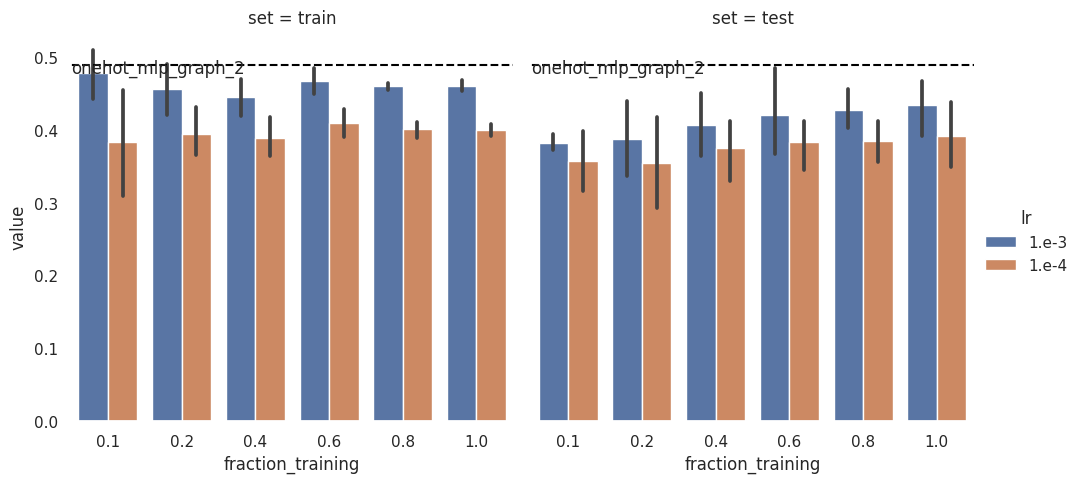

In [34]:
metric_name = 'accuracy'

selection = best_labels[metric_name].copy()

focus = ['fraction_training', 'lr']


for f in focus:
    selection.pop(f)
selection['epoch'] = 990

w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.catplot(data=metrics_df[w1 & w2], x=focus[0], hue=focus[1], y='value', col='set', kind='bar', sharey=True)

for idx, dfg in baseline.groupby(level=0):
    for ax in fg.axes_dict.values():
        ax.axhline(dfg[(idx, metric_name)], color='black', ls='--')
        ax.text(-0.5, dfg[(idx, metric_name)]*0.99,  idx, rotation=0, size=12, va='center')

print('|'.join(f'{k}={v}' for k, v in selection.items()))

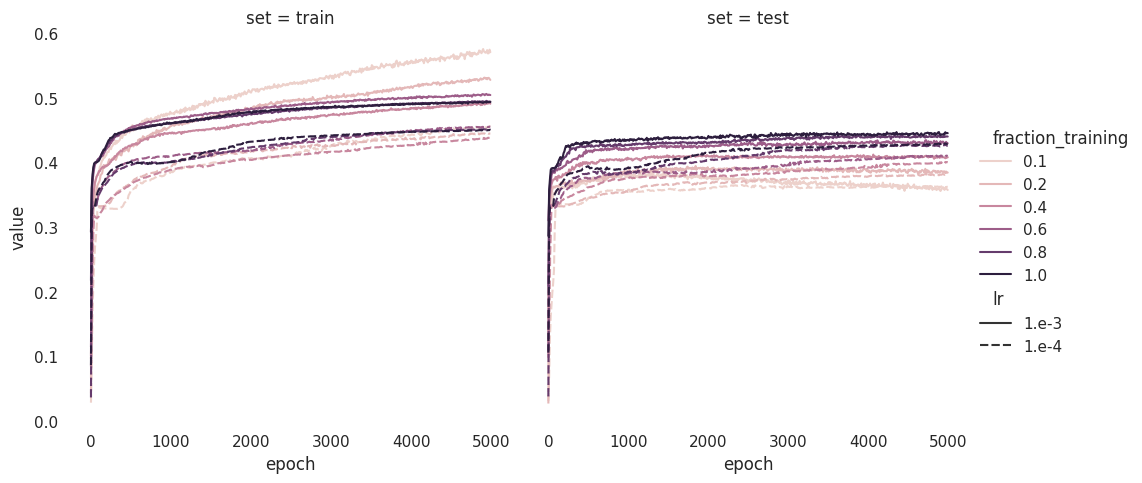

In [35]:
metric_name = 'accuracy'

selection = best_labels[metric_name].copy()

focus = ['fraction_training','lr']



for f in focus:
    selection.pop(f)
# selection['epoch'] = 990
# selection['fraction_training'] = 1.0


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1], y='value', col='set', kind='line', ci=None)

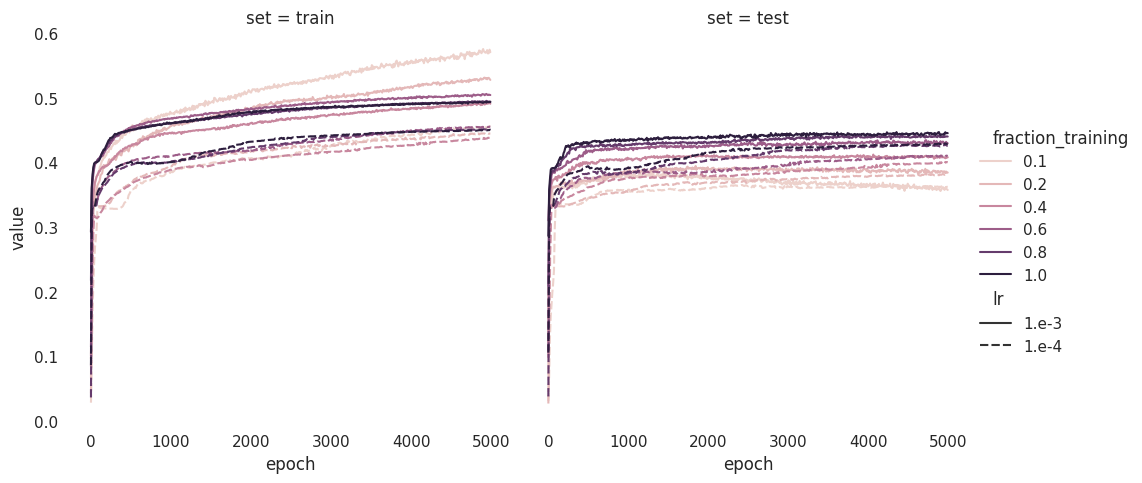

In [37]:
metric_name = 'accuracy'

selection = best_labels[metric_name].copy()

focus = ['fraction_training','lr']



for f in focus:
    selection.pop(f)
# selection['epoch'] = 990
# selection['fraction_training'] = 1.0


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1] if len(focus) == 2 else None, y='value', col='set', kind='line', ci=None)

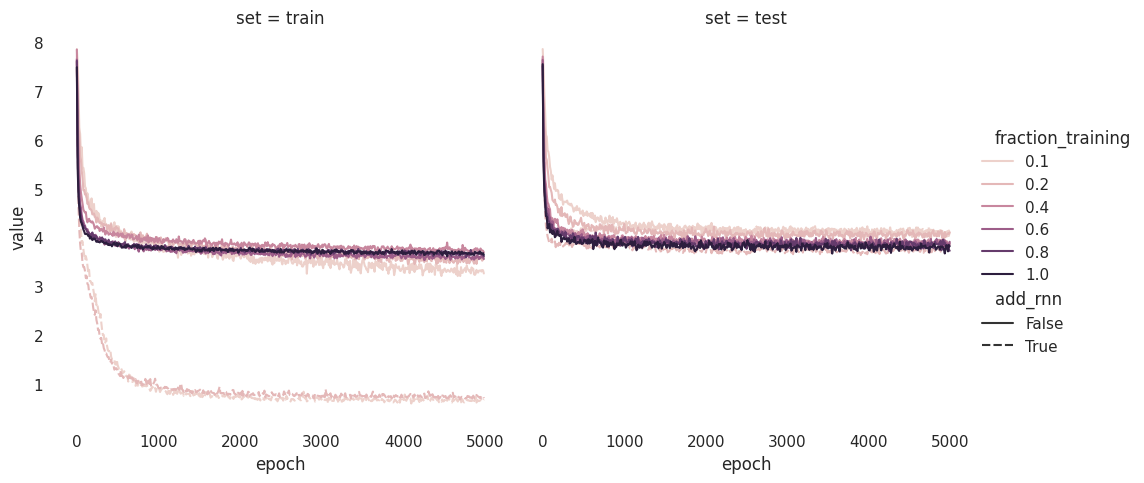

In [41]:
metric_name = 'mean_absolute_error'

selection = best_labels[metric_name].copy()

focus = ['fraction_training','add_rnn']


for f in focus:
    selection.pop(f)
# selection['epoch'] = 990
# selection['fraction_training'] = 1.0
selection['strategy'] = 'sampling'


w1 = pd.concat(
    (metrics_df[k] == v
    for k,v in selection.items()), axis=1
).all(1)

w2 = (
    (metrics_df['name'] == metric_name) 
)

fg = sns.relplot(data=metrics_df[w1 & w2].copy(), x='epoch', hue=focus[0], style=focus[1] if len(focus) == 2 else None, y='value', col='set', kind='line', ci=None)